In [2]:
import sys
print(sys.executable)

/Users/stevenyang/projects/lecoach/v1/.venv/bin/python


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, log_loss, accuracy_score
from sklearn.calibration import calibration_curve
import joblib
import sys
import os

# Add the project root to the path so we can import our database modules
sys.path.append(os.path.abspath('../..'))
from v1.db.db import SessionLocal, engine
from v1.db.models import PlayByPlay, Game, Team

2025-02-26 23:19:23,543 - v1.db.db - INFO - Database connection established successfully


Database connection test successful!
Database tables created successfully!


In [4]:
# Configure plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
from sqlalchemy import text
import time
# %% [Cell 2] - Extract data
def extract_play_by_play_data(limit=None, export_csv=False):
    """
    Extract play-by-play data from the database and determine win outcomes
    using only data from the PlayByPlay table.
    
    Parameters:
    -----------
    limit : int, optional
        Limit the number of games to process (for testing)
    export_csv : bool, optional
        Whether to export the data to CSV for inspection
    """
    start_time = time.time()
    
    print(f"Starting play-by-play data extraction...")
    
    with SessionLocal() as session:
        # Count total records for progress reporting
        total_count = session.query(PlayByPlay.game_id.distinct()).count()
        print(f"Found {total_count} games in database.")
        
        if limit:
            print(f"Limiting to {limit} games for testing.")
            # Get limited set of game IDs
            game_ids = [g[0] for g in session.query(PlayByPlay.game_id.distinct()).limit(limit).all()]
        else:
            # Get all game IDs
            game_ids = [g[0] for g in session.query(PlayByPlay.game_id.distinct()).all()]
        
        # Process games in chunks
        chunk_size = 10  # Process 10 games at a time
        all_data = []
        
        for i in range(0, len(game_ids), chunk_size):
            chunk_start = time.time()
            chunk_game_ids = game_ids[i:i+chunk_size]
            print(f"Processing games {i+1}-{i+len(chunk_game_ids)} of {len(game_ids)}...")
            
            # Query only the necessary fields for the current chunk of games
            query_start = time.time()
            chunk_query = session.query(
                PlayByPlay.id,
                PlayByPlay.game_id,
                PlayByPlay.period,
                PlayByPlay.time_remaining,
                PlayByPlay.seconds_remaining,
                PlayByPlay.score_margin,
                PlayByPlay.home_score,
                PlayByPlay.away_score,
                PlayByPlay.is_home_offense,
                PlayByPlay.bonus,
                PlayByPlay.double_bonus,
                PlayByPlay.timeouts_remaining_home,
                PlayByPlay.timeouts_remaining_away,
                PlayByPlay.points_last_minute,
                PlayByPlay.lead_changes,
                PlayByPlay.largest_lead,
                PlayByPlay.winning_team
            ).filter(PlayByPlay.game_id.in_(chunk_game_ids)).all()
            
            print(f"  Query completed in {time.time() - query_start:.2f} seconds. Found {len(chunk_query)} plays.")
            
            # Convert to list of dictionaries
            df_start = time.time()
            chunk_data = [
                {
                    'id': play[0],
                    'game_id': play[1],
                    'period': play[2],
                    'time_remaining': play[3],
                    'seconds_remaining': play[4],
                    'score_margin': play[5],
                    'home_score': play[6],
                    'away_score': play[7],
                    'is_home_offense': play[8],
                    'bonus': play[9],
                    'double_bonus': play[10],
                    'timeouts_remaining_home': play[11],
                    'timeouts_remaining_away': play[12],
                    'points_last_minute': play[13],
                    'lead_changes': play[14],
                    'largest_lead': play[15],
                    'winning_team': play[16]
                } for play in chunk_query
            ]
            all_data.extend(chunk_data)
            print(f"  Chunk processed in {time.time() - chunk_start:.2f} seconds.")
        
        # Convert all data to DataFrame
        print(f"Converting all data to DataFrame...")
        df_start = time.time()
        pbp_df = pd.DataFrame(all_data)
        print(f"DataFrame conversion completed in {time.time() - df_start:.2f} seconds.")
        
        # Check for NaN values in the raw data
        nan_counts = pbp_df.isna().sum()
        print(f"NaN counts in raw data:")
        for col, count in nan_counts[nan_counts > 0].items():
            print(f"  {col}: {count} NaNs ({count/len(pbp_df)*100:.2f}%)")
        
        if len(pbp_df) == 0:
            print("Warning: No play-by-play data found!")
            return pd.DataFrame()
        
        # Process game outcomes
        print(f"Processing game outcomes...")
        outcome_start = time.time()
        
        # Get the final play from each game with valid score data
        print(f"Finding final scores for each game...")
        game_outcomes = {}
        
        for game_id, game_data in pbp_df.groupby('game_id'):
            # Skip games with no score data
            if game_data['home_score'].max() == 0 and game_data['away_score'].max() == 0:
                continue
            
            # Get the last play of the game (last period, least time remaining)
            final_plays = game_data.sort_values(['period', 'seconds_remaining'], 
                                               ascending=[False, True])
            
            if len(final_plays) > 0:
                # Take the first row (last period, least time)
                final_play = final_plays.iloc[0]
                
                # Determine winner based on comparing home vs away score
                home_score = final_play['home_score']
                away_score = final_play['away_score']
                
                if home_score > away_score:
                    # Home team won
                    home_win = 1
                elif away_score > home_score:
                    # Away team won
                    home_win = 0
                else:
                    # It's a tie
                    home_win = 0.5
                
                game_outcomes[game_id] = {
                    'home_win': home_win,
                    'final_score_margin': home_score - away_score,
                    'home_score': home_score,
                    'away_score': away_score,
                    'is_tie': home_score == away_score,
                    'final_period': final_play['period']
                }
        
        # Convert outcomes to DataFrame
        outcomes_df = pd.DataFrame.from_dict(game_outcomes, orient='index')
        outcomes_df.index.name = 'game_id'
        outcomes_df = outcomes_df.reset_index()
        
        # Get stats on outcomes
        home_wins = (outcomes_df['home_win'] == 1).sum()
        away_wins = (outcomes_df['home_win'] == 0).sum()
        ties = (outcomes_df['home_win'] == 0.5).sum()
        
        print(f"Game outcomes: {len(outcomes_df)} games processed")
        print(f"  Home wins: {home_wins} ({home_wins/len(outcomes_df)*100:.1f}%)")
        print(f"  Away wins: {away_wins} ({away_wins/len(outcomes_df)*100:.1f}%)")
        print(f"  Ties: {ties} ({ties/len(outcomes_df)*100:.1f}%)")
        
        print(f"Game outcome processing completed in {time.time() - outcome_start:.2f} seconds.")
        
        # Merge win information back to the original dataframe
        print(f"Merging win information back to play-by-play data...")
        merge_start = time.time()
        merged_df = pd.merge(pbp_df, outcomes_df[['game_id', 'home_win']], on='game_id', how='left')
        print(f"Data merging completed in {time.time() - merge_start:.2f} seconds.")
        
        # Check for NaN values after merging
        nan_counts = merged_df.isna().sum()
        print(f"NaN counts after merging:")
        for col, count in nan_counts[nan_counts > 0].items():
            print(f"  {col}: {count} NaNs ({count/len(merged_df)*100:.2f}%)")
        
        valid_plays_count = merged_df.dropna(subset=['home_win']).shape[0]
        print(f"Valid plays with outcome data: {valid_plays_count} ({valid_plays_count/len(merged_df)*100:.2f}%)")
        
        # Filter out games with ties (home_win = 0.5)
        print(f"Before filtering: {len(merged_df)} plays")

        # Filter out tie games
        tied_games = merged_df[merged_df['home_win'] == 0.5]['game_id'].unique()
        if len(tied_games) > 0:
            print(f"Removing {len(tied_games)} tied games")
            merged_df = merged_df[merged_df['home_win'] != 0.5]

        # Filter out suspicious data (games with all zeros or missing key information)
        suspicious_games = []

        # Check each game for suspicious data patterns
        for game_id, game_data in merged_df.groupby('game_id'):
            max_home_score = game_data['home_score'].max()
            max_away_score = game_data['away_score'].max()
            max_period = game_data['period'].max()
            
            # Criteria for suspicious games:
            # 1. Games where neither team scored
            # 2. Games that don't reach at least period 2
            # 3. Games with very few plays (less than 20)
            if (max_home_score == 0 and max_away_score == 0) or \
               (max_period < 2) or \
               (len(game_data) < 20):
                suspicious_games.append(game_id)

        if len(suspicious_games) > 0:
            print(f"Removing {len(suspicious_games)} games with suspicious data")
            suspicious_df = merged_df[merged_df['game_id'].isin(suspicious_games)]
            
            if export_csv:
                suspicious_df.to_csv("suspicious_games.csv", index=False)
                print(f"Suspicious games exported to suspicious_games.csv")
            
            merged_df = merged_df[~merged_df['game_id'].isin(suspicious_games)]

        print(f"After filtering: {len(merged_df)} plays ({len(merged_df['game_id'].unique())} games)")

        # Additional check for completely empty fields that might be problematic for modeling
        null_percents = merged_df.isnull().mean() * 100
        if any(null_percents > 5):
            print("Warning: Some columns have significant missing data:")
            for col, pct in null_percents[null_percents > 5].items():
                print(f"  {col}: {pct:.1f}% missing")

        # Export to CSV if requested
        if export_csv:
            csv_file = "play_by_play_data.csv"
            merged_df.to_csv(csv_file, index=False)
            print(f"Data exported to {csv_file}")
            
            # Export the outcomes summary
            outcomes_df.to_csv("game_outcomes.csv", index=False)
            print(f"Game outcomes exported to game_outcomes.csv")
            
            # Also export a sample of games with NaN values if any
            nan_games = merged_df[merged_df.isna().any(axis=1)]['game_id'].unique()
            if len(nan_games) > 0:
                nan_sample = merged_df[merged_df['game_id'].isin(nan_games[:5])]
                nan_sample.to_csv("nan_sample.csv", index=False)
                print(f"Sample of games with NaN values exported to nan_sample.csv")
        
        return merged_df

# Extract with CSV export and then filter for clean data
pbp_data = extract_play_by_play_data(limit=6000, export_csv=True)

# Further clean the data for modeling by removing any remaining NaN values
pbp_data_clean = pbp_data.dropna()
print(f"Final clean data shape: {pbp_data_clean.shape} ({len(pbp_data_clean['game_id'].unique())} unique games)")

Starting play-by-play data extraction...
Found 5580 games in database.
Limiting to 6000 games for testing.
Processing games 1-10 of 5580...
  Query completed in 0.24 seconds. Found 2468 plays.
  Chunk processed in 0.24 seconds.
Processing games 11-20 of 5580...
  Query completed in 0.12 seconds. Found 2549 plays.
  Chunk processed in 0.12 seconds.
Processing games 21-30 of 5580...
  Query completed in 0.14 seconds. Found 2518 plays.
  Chunk processed in 0.14 seconds.
Processing games 31-40 of 5580...
  Query completed in 0.19 seconds. Found 2502 plays.
  Chunk processed in 0.19 seconds.
Processing games 41-50 of 5580...
  Query completed in 0.13 seconds. Found 2611 plays.
  Chunk processed in 0.13 seconds.
Processing games 51-60 of 5580...
  Query completed in 0.22 seconds. Found 2528 plays.
  Chunk processed in 0.22 seconds.
Processing games 61-70 of 5580...
  Query completed in 0.11 seconds. Found 2608 plays.
  Chunk processed in 0.11 seconds.
Processing games 71-80 of 5580...
  Quer

In [9]:
# %% [Cell 3] - Engineer features
def engineer_features(df):
    """
    Create and transform features for the win probability model.
    """
    # Make a copy to avoid modifying the original
    X = df.copy()
    
    # Target variable
    y = X['home_win']
    
    # Calculate total time remaining in the game
    # For a regulation game with 4 periods of 10 minutes each (600 seconds)
    seconds_per_period = 600  # 10 minutes per period
    total_periods = 4  # Regular game has 4 periods
    
    # Handle overtime periods differently
    # For regulation time (periods 1-4), calculate normally
    # For overtime (periods 5+), set remaining time to just what's left in current period
    X['is_overtime'] = X['period'] > total_periods
    
    # Calculate time remaining in the entire game
    X['total_seconds_remaining'] = np.where(
        X['is_overtime'],
        # For overtime: just the time remaining in current period
        X['time_remaining'] / 10,
        # For regulation: regular calculation
        ((total_periods - X['period']) * seconds_per_period) + (X['time_remaining'] / 10)
    )
    
    # Transform time remaining - higher impact as game progresses
    # Using log transformation to emphasize late-game situations
    X['time_remaining_transformed'] = np.log1p(X['total_seconds_remaining'])
    
    # Game completion percentage (0% at start, 100% at end)
    total_game_seconds = total_periods * seconds_per_period
    # For overtime, set completion to >100%
    X['game_completion_pct'] = np.where(
        X['is_overtime'],
        1.0 + ((X['period'] - total_periods) / 10),  # Over 100% for overtime
        1 - (X['total_seconds_remaining'] / total_game_seconds)
    )
    
    # Relative score (normalized by total points to handle different game paces)
    X['total_score'] = X['home_score'] + X['away_score']
    
    # Handle division by zero more carefully
    X['score_margin_pct'] = np.where(
        X['total_score'] > 0,
        X['score_margin'] / X['total_score'],
        0  # When total_score is 0, set to 0
    )
    
    # Interaction: Score margin × time remaining
    # Score differences matter more as time decreases
    X['margin_time_interaction'] = X['score_margin'] * (1 / np.log1p(X['total_seconds_remaining'] + 1))
    
    # Game phase indicators
    X['is_first_half'] = (X['period'] <= 2).astype(int)
    X['is_last_period'] = (X['period'] >= 4).astype(int)
    X['is_overtime'] = X['is_overtime'].astype(int)  # Add overtime as a feature
    X['is_last_two_min'] = (X['total_seconds_remaining'] <= 120).astype(int)
    
    # Possession value (offense opportunity)
    X['home_has_ball'] = X['is_home_offense'].astype(int)
    
    # Momentum indicators
    X['timeout_advantage'] = X['timeouts_remaining_home'] - X['timeouts_remaining_away']
    
    # Select features for the model
    features = [
        'score_margin', 'score_margin_pct', 'time_remaining_transformed',
        'game_completion_pct', 'margin_time_interaction', 'is_first_half', 
        'is_last_period', 'is_overtime', 'is_last_two_min', 'home_has_ball', 
        'points_last_minute', 'lead_changes'
    ]
    
    # Make sure there are no NaN values in our features
    X_features = X[features]
    
    # Check for any remaining NaN values
    nan_counts = X_features.isna().sum()
    has_nans = nan_counts.any()
    
    if has_nans:
        # Print columns with NaN values
        print("Warning: NaN values found in features:")
        for col, count in nan_counts[nan_counts > 0].items():
            print(f"  {col}: {count} NaNs ({count/len(X_features)*100:.2f}%)")
        
        # Export problematic rows to CSV
        nan_rows = X[X_features.isna().any(axis=1)].copy()
        
        # Add information about which columns have NaNs
        for col in X_features.columns:
            nan_rows[f"{col}_isnan"] = nan_rows[col].isna()
        
        # Export to CSV
        nan_rows.to_csv("nan_problem_rows.csv", index=False)
        print(f"Exported {len(nan_rows)} problematic rows to nan_problem_rows.csv")
        
        # Export a random sample of valid rows for comparison
        valid_rows = X[~X_features.isna().any(axis=1)].sample(min(100, len(X)))
        valid_rows.to_csv("valid_sample_rows.csv", index=False)
        print(f"Exported {len(valid_rows)} valid rows to valid_sample_rows.csv for comparison")
        
        # Drop rows with NaN values
        mask = ~X_features.isna().any(axis=1)
        X_features = X_features[mask]
        y = y[mask]
    
    # Check for infinities
    inf_counts = np.isinf(X_features).sum()
    has_infs = inf_counts.any()
    
    if has_infs:
        # Print columns with infinity values
        print("Warning: Infinity values found in features:")
        for col, count in inf_counts[inf_counts > 0].items():
            print(f"  {col}: {count} infinities ({count/len(X_features)*100:.2f}%)")
        
        # Replace infinities with large values
        X_features = X_features.replace([np.inf, -np.inf], np.nan)
        X_features = X_features.fillna(X_features.abs().max() * 10)
    
    return X_features, y

# Engineer features
X, y = engineer_features(pbp_data_clean)

# Display the features
X.head()

,score_margin,score_margin_pct,time_remaining_transformed,game_completion_pct,margin_time_interaction,is_first_half,is_last_period,is_overtime,is_last_two_min,home_has_ball,points_last_minute,lead_changes
2,-29,-0.460317,6.999422,0.543750,-4.142659,0,0,0,0,1,5,0
44,0,0.000000,7.772753,0.010833,0.000000,1,0,0,0,1,0,0
45,2,1.000000,7.766841,0.016667,0.257491,1,0,0,0,0,2,0
46,0,0.000000,7.757051,0.026250,0.000000,1,0,0,0,1,4,0
47,0,0.000000,7.748891,0.034167,0.000000,1,0,0,0,0,4,0


Training data: 951175 plays from 3731 games
Testing data: 409386 plays from 1600 games


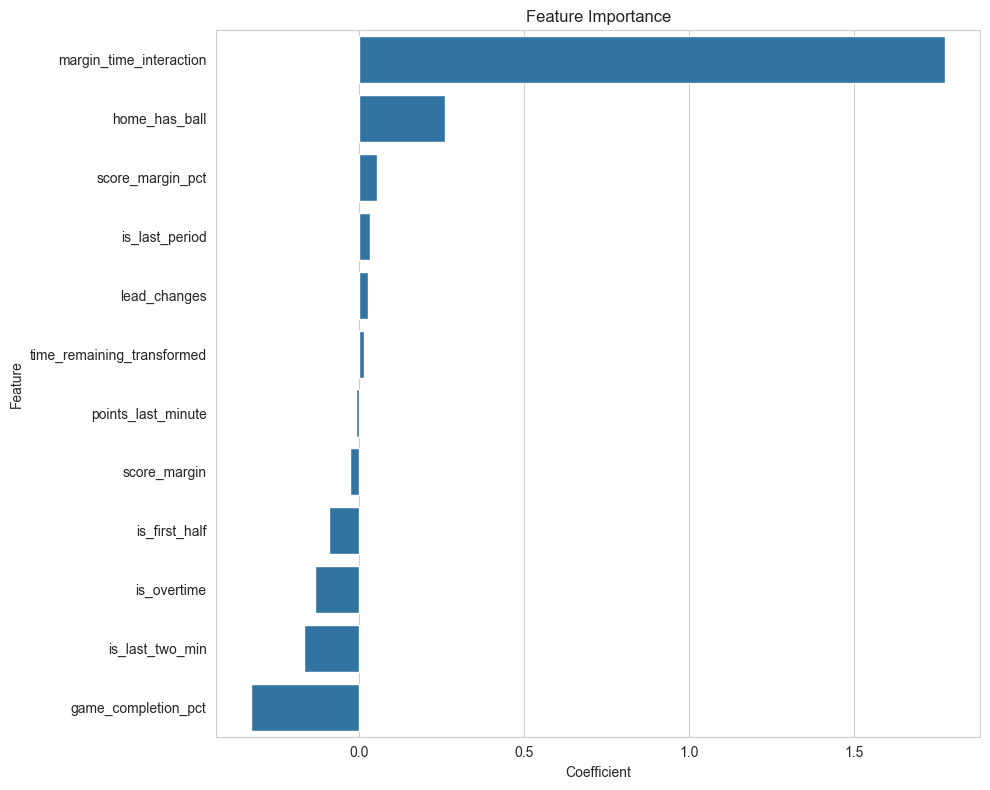

,Feature,Coefficient
4,margin_time_interaction,1.777114
9,home_has_ball,0.260426
1,score_margin_pct,0.054807
6,is_last_period,0.031577
11,lead_changes,0.026583
2,time_remaining_transformed,0.012930
10,points_last_minute,-0.008976
0,score_margin,-0.029023
5,is_first_half,-0.092568
7,is_overtime,-0.135935


In [10]:
# %% [Cell 4] - Split data
def split_by_games(pbp_data, test_size=0.3, random_state=42):
    """
    Split the data by games to avoid data leakage.
    """
    # Get unique game IDs
    game_ids = pbp_data['game_id'].unique()
    
    # Split game IDs into train and test
    train_games, test_games = train_test_split(game_ids, test_size=test_size, random_state=random_state)
    
    # Get train and test indices
    train_indices = pbp_data[pbp_data['game_id'].isin(train_games)].index
    test_indices = pbp_data[pbp_data['game_id'].isin(test_games)].index
    
    return train_indices, test_indices

# Get train/test indices
train_indices, test_indices = split_by_games(pbp_data)

# Split the data
X_train, y_train = X.loc[train_indices], y.loc[train_indices]
X_test, y_test = X.loc[test_indices], y.loc[test_indices]

print(f"Training data: {X_train.shape[0]} plays from {len(pbp_data.loc[train_indices, 'game_id'].unique())} games")
print(f"Testing data: {X_test.shape[0]} plays from {len(pbp_data.loc[test_indices, 'game_id'].unique())} games")

# %% [markdown]
# ## 4. Train the Model
# 
# Now we'll train a logistic regression model.

# %% [Cell 5] - Train model
def train_model(X_train, y_train):
    """
    Train a logistic regression model for win probability.
    """
    # Create and train the model
    model = LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000)
    model.fit(X_train, y_train)
    
    # Display feature importance
    coefficients = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': model.coef_[0]
    }).sort_values('Coefficient', ascending=False)
    
    return model, coefficients

# Train the model
model, coefficients = train_model(X_train, y_train)

# Display feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Display coefficients
coefficients

Accuracy: 0.8161
Brier Score: 0.1235 (lower is better)
Log Loss: 0.3805 (lower is better)


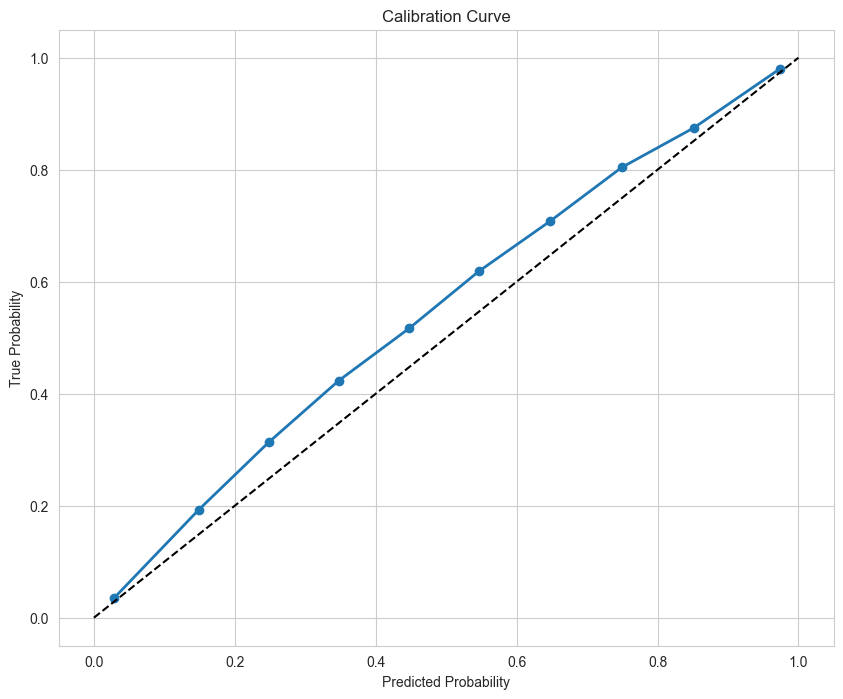

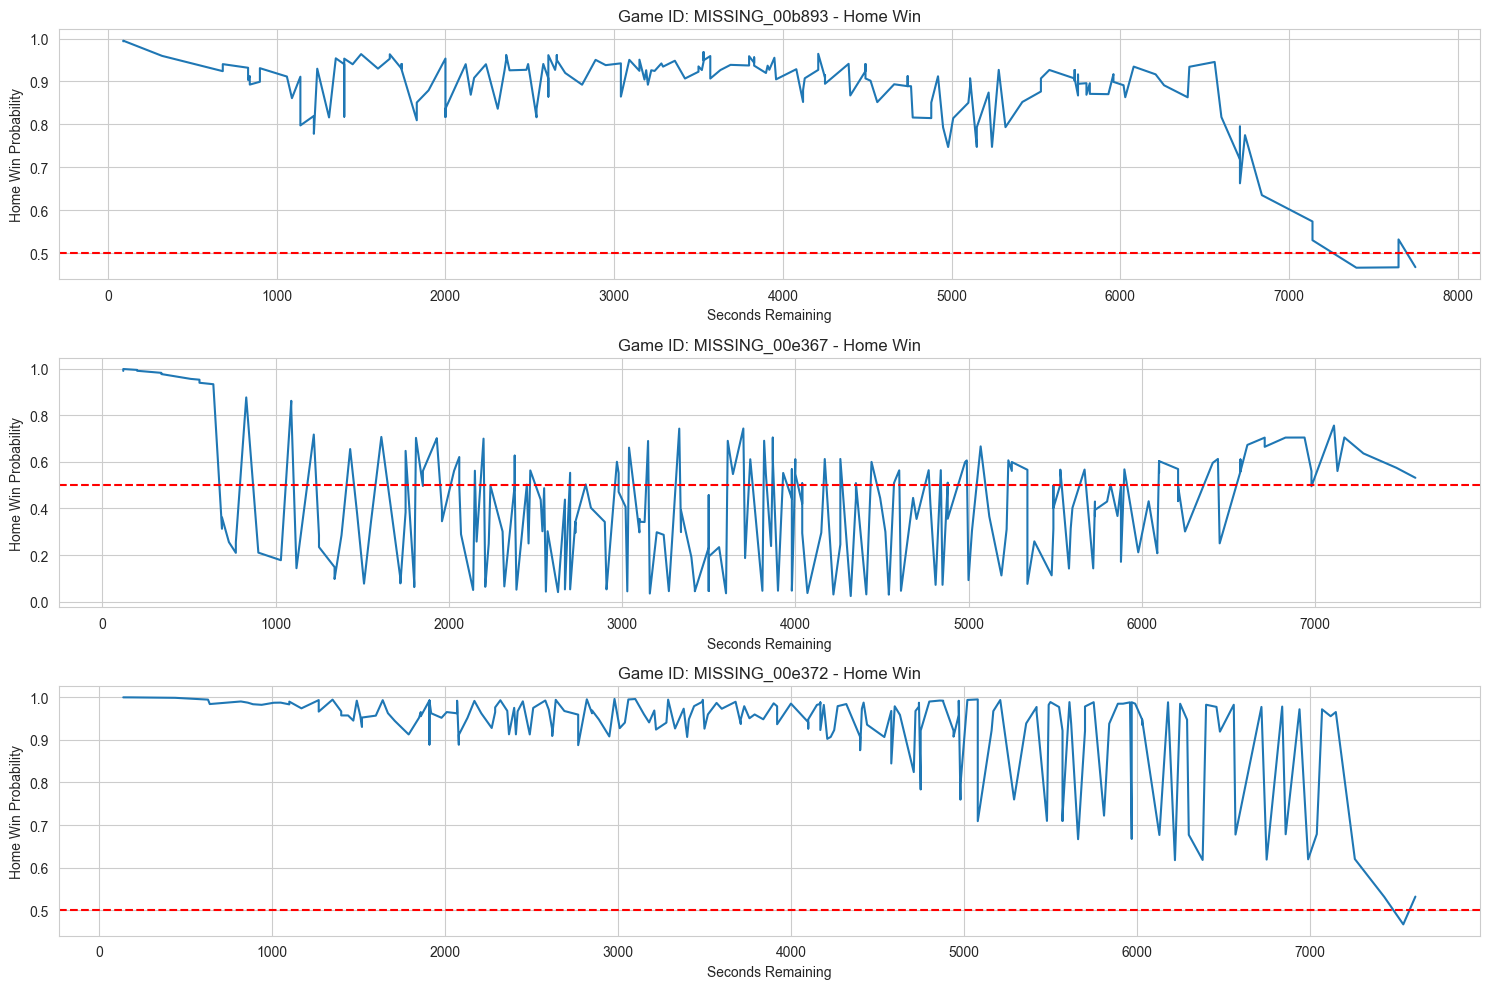

In [11]:
# %% [Cell 6] - Evaluate model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the win probability model.
    """
    # Get predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    brier = brier_score_loss(y_test, y_pred_proba)
    log = log_loss(y_test, y_pred_proba)
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Brier Score: {brier:.4f} (lower is better)")
    print(f"Log Loss: {log:.4f} (lower is better)")
    
    # Plot calibration curve
    plt.figure(figsize=(10, 8))
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.grid(True)
    plt.show()
    
    # Plot win probability over time for a few games
    sample_games = pbp_data.loc[test_indices, 'game_id'].unique()[:3]
    
    plt.figure(figsize=(15, 10))
    for i, game_id in enumerate(sample_games):
        game_data = pbp_data[pbp_data['game_id'] == game_id].sort_values('seconds_remaining', ascending=False)
        game_features = X.loc[game_data.index]
        win_probs = model.predict_proba(game_features)[:, 1]
        
        plt.subplot(len(sample_games), 1, i+1)
        plt.plot(game_data['seconds_remaining'], win_probs)
        plt.axhline(y=0.5, color='r', linestyle='--')
        plt.title(f"Game ID: {game_id} - {'Home Win' if game_data['home_win'].iloc[0] == 1 else 'Away Win'}")
        plt.xlabel('Seconds Remaining')
        plt.ylabel('Home Win Probability')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return y_pred_proba

# Evaluate the model
y_pred_proba = evaluate_model(model, X_test, y_test)

Top 10 highest impact plays for game MISSING_00b744:
1. WPA: 0.5197, Period: 1, Time Remaining: 5890 sec
2. WPA: 0.5197, Period: 1, Time Remaining: 6130 sec
3. WPA: 0.5195, Period: 1, Time Remaining: 6280 sec
4. WPA: 0.4553, Period: 1, Time Remaining: 6500 sec
5. WPA: 0.4196, Period: 1, Time Remaining: 6700 sec
6. WPA: 0.4146, Period: 1, Time Remaining: 5690 sec
7. WPA: 0.3757, Period: 1, Time Remaining: 6410 sec
8. WPA: 0.3627, Period: 1, Time Remaining: 4110 sec
9. WPA: 0.3552, Period: 1, Time Remaining: 3320 sec
10. WPA: 0.3520, Period: 1, Time Remaining: 5500 sec


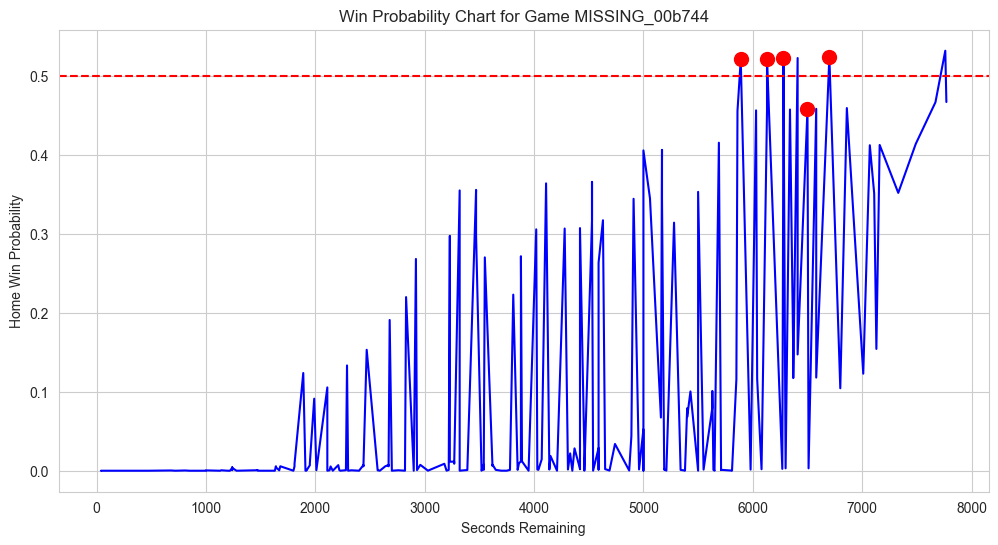

In [12]:
# %% [Cell 7] - Calculate play impact
def calculate_play_impact(model, pbp_data, X):
    """
    Calculate the impact (win probability added) for each play.
    """
    # Get a sample game for demonstration
    sample_game_id = pbp_data['game_id'].iloc[0]
    game_data = pbp_data[pbp_data['game_id'] == sample_game_id].sort_values('seconds_remaining', ascending=False)
    game_features = X.loc[game_data.index]
    
    # Predict win probabilities
    win_probs = model.predict_proba(game_features)[:, 1]
    
    # Add win probability to the game data
    game_data = game_data.copy()
    game_data['win_probability'] = win_probs
    
    # Calculate win probability added (WPA)
    game_data['win_probability_prev'] = game_data['win_probability'].shift(1)
    game_data['wpa'] = game_data['win_probability'] - game_data['win_probability_prev']
    
    # Display the plays with highest impact
    impact_plays = game_data.sort_values('wpa', ascending=False).head(10)
    print(f"Top 10 highest impact plays for game {sample_game_id}:")
    
    for i, (_, play) in enumerate(impact_plays.iterrows(), 1):
        print(f"{i}. WPA: {play['wpa']:.4f}, Period: {play['period']}, Time Remaining: {play['seconds_remaining']} sec")
    
    # Plot win probability with key moments highlighted
    plt.figure(figsize=(12, 6))
    plt.plot(game_data['seconds_remaining'], game_data['win_probability'], 'b-')
    
    # Highlight top 5 impact plays
    top5_impacts = game_data.sort_values('wpa', ascending=False).head(5)
    plt.scatter(top5_impacts['seconds_remaining'], top5_impacts['win_probability'], 
                color='red', s=100, zorder=5)
    
    plt.axhline(y=0.5, color='r', linestyle='--')
    plt.title(f"Win Probability Chart for Game {sample_game_id}")
    plt.xlabel('Seconds Remaining')
    plt.ylabel('Home Win Probability')
    plt.grid(True)
    plt.show()
    
    return game_data

# Calculate play impact
impact_data = calculate_play_impact(model, pbp_data, X)

In [13]:
# %% [Cell 8] - Save model
def save_model(model, filename='win_probability_model.joblib'):
    """
    Save the trained model to disk.
    """
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Save the model
    model_path = os.path.join('models', filename)
    joblib.dump(model, model_path)
    
    print(f"Model saved to {model_path}")
    
    # Save feature list
    feature_path = os.path.join('models', 'feature_list.joblib')
    joblib.dump(list(X.columns), feature_path)
    
    print(f"Feature list saved to {feature_path}")

# Save the model
save_model(model)

Model saved to models/win_probability_model.joblib
Feature list saved to models/feature_list.joblib


In [29]:
# %% [Cell 9] - Use model in production
def load_model(filename='win_probability_model.joblib'):
    """
    Load the trained model from disk.
    """
    model_path = os.path.join('models', filename)
    feature_path = os.path.join('models', 'feature_list.joblib')
    
    model = joblib.load(model_path)
    features = joblib.load(feature_path)
    
    return model, features

def predict_win_probability(model, features, game_state):
    """
    Predict win probability for a given game state.
    """
    # Create feature vector
    feature_vector = {}
    
    # Calculate total time remaining
    seconds_per_period = 600  # 10 minutes per period
    total_periods = 4  # Regular game has 4 periods
    
    # Check if we're in overtime
    is_overtime = game_state['period'] > total_periods
    
    # Calculate total seconds remaining properly
    if is_overtime:
        # For overtime: just the time remaining in current period
        total_seconds_remaining = game_state['time_remaining'] / 10
    else:
        # For regulation: regular calculation
        total_seconds_remaining = ((total_periods - game_state['period']) * seconds_per_period) + \
                                 (game_state['time_remaining'] / 10)
    
    # Basic features
    feature_vector['score_margin'] = game_state['score_margin']
    feature_vector['time_remaining_transformed'] = np.log1p(total_seconds_remaining)
    
    # Game completion percentage
    total_game_seconds = total_periods * seconds_per_period
    if is_overtime:
        feature_vector['game_completion_pct'] = 1.0 + ((game_state['period'] - total_periods) / 10)
    else:
        feature_vector['game_completion_pct'] = 1 - (total_seconds_remaining / total_game_seconds)
    
    # Derived features
    total_score = game_state['home_score'] + game_state['away_score']
    feature_vector['score_margin_pct'] = game_state['score_margin'] / max(total_score, 1)
    feature_vector['margin_time_interaction'] = game_state['score_margin'] * (1 / np.log1p(total_seconds_remaining + 1))
    
    # Game phase
    feature_vector['is_first_half'] = 1 if game_state['period'] <= 2 else 0
    feature_vector['is_last_period'] = 1 if game_state['period'] >= 4 else 0
    feature_vector['is_overtime'] = 1 if is_overtime else 0
    feature_vector['is_last_two_min'] = 1 if total_seconds_remaining <= 120 else 0
    
    # Other features
    feature_vector['home_has_ball'] = 1 if game_state['is_home_offense'] else 0
    feature_vector['timeout_advantage'] = game_state['timeouts_remaining_home'] - game_state['timeouts_remaining_away']
    feature_vector['bonus'] = 1 if game_state['bonus'] else 0
    feature_vector['double_bonus'] = 1 if game_state['double_bonus'] else 0
    feature_vector['points_last_minute'] = game_state['points_last_minute']
    feature_vector['lead_changes'] = game_state['lead_changes']
    
    # Create DataFrame with the right features in the right order
    feature_df = pd.DataFrame([{f: feature_vector.get(f, 0) for f in features}])
    
    # Predict probability
    win_prob = model.predict_proba(feature_df)[0, 1]
    
    return win_prob

# Example usage
model, features = load_model()

# Example game state
game_state = {
    'score_margin': 2,            # Home team up by 5
    'home_score': 70,
    'away_score': 65,
    'time_remaining': 100,      # 5 minutes left
    'period': 4,                  # 4th quarter
    'is_home_offense': True,      # Home team has the ball
    'bonus': True,                # Team in bonus
    'double_bonus': False,
    'timeouts_remaining_home': 2,
    'timeouts_remaining_away': 1,
    'points_last_minute': 6,
    'lead_changes': 8
}

win_prob = predict_win_probability(model, features, game_state)
print(f"Home team win probability: {win_prob:.4f} ({win_prob*100:.1f}%)")

Home team win probability: 0.7724 (77.2%)
